## Objective:
### Behavioural  customer segmentation.
#### Predict "inferred" gender for .... customers.  

#### Note: Please note that the following recommendation solution is conducted in a very short limit of time, considering my time schedule.

## Approach:
### Because there is no label as Gender, I need to use Unsupervised approach. I could choose traditional techniques such as K-mean for this clustering, but, since the approach might be going through productionization by having BigData, I choose a Deep Learning based technique for that. I believe, the performance becomes better by considering more data. 

### Steps from scratch:
#### Step 1: Load Data:  After Unhash the files, I create a Sqlite connection to read and convert to DataFrame.
#### Step 2: Data Preparation: I go through EDA techniques, make some corrections, and delete duplications.  
#### Step 3: Feature Engineering: Mostly focused on related features to Gender. Find the relationship between different attributes. Create new features based on the conducted relationships.  
#### Step 4: Build Model: I use deep Autoencoder to learn from historical data. Then, pick the embedded layer from Autoencoder and feed that one to Gaussian Mixture Model in order to categorize customers into 2 clusters, called male and female.
#### Step 5: Try to find clear insight and create a PowerPoint to show to SMEs and Stakeholders. I believe this step is very important to clearly convey excellent technical outcomes to businesspeople.




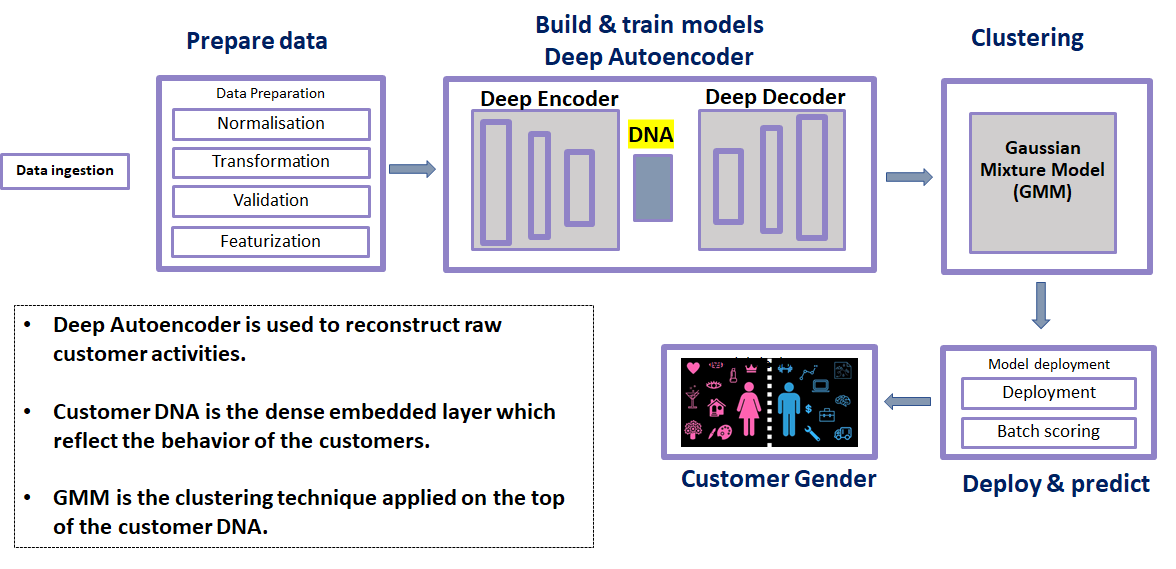

In [1]:
from IPython.display import Image
Image(filename = "approach.png", width=925, height=750)

## Libraries

In [11]:
import os
import sys
import subprocess
import shlex
import time
import shutil

import numpy as np
import pandas as pd


from IPython.display import display
from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style('white')

# import pandas_profiling as pp
import plotly.plotly as py
from plotly.offline import init_notebook_mode
init_notebook_mode()

from keras.utils import plot_model
from IPython.display import Image

from sklearn.cluster import KMeans
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal as mvn
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, RepeatVector, TimeDistributed, Lambda, Flatten, Concatenate, Reshape
from sklearn.preprocessing import StandardScaler
# from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import LabelEncoder


from keras.datasets import mnist
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


## Step 1: Loading Data 

In [1]:
import sqlite3
import pandas as pd
pd.set_option('display.max_columns', None)

con = sqlite3.connect('test_data.db')

#This function helps me to find the name of ... Table
def sql_fetch(con): 
    cursorObj = con.cursor() 
    cursorObj.execute('SELECT name from sqlite_master where type= "table"') 
    print(cursorObj.fetchall())
 
sql_fetch(con)

[('customers',)]


#### So, as above, the name of ..... Table is "customers". I use this name on the below query, and convert to DataFrame, as below

In [3]:
df = pd.read_sql_query("SELECT * FROM customers", con)

df.head()

,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue
0,64f7d7dd7a59bba7168cc9c960a5c60e,2091,15672,N,17,50,0,1,0,4,1,3,1,0,0,0,46,2,2,35,7,2,1,1,0,4,0,0,0,0,17,0,0,0,0,1,0,16,4554.39,248.65,0.3364,3584.4818,6946.34
1,fa7c64efd5c037ff2abcce571f9c1712,2082,528,Y,13,26,0,5,0,4,2,0,0,1,0,0,24,0,2,16,2,0,4,4,0,3,0,0,0,12,1,0,0,0,0,9,0,4,629.03,0.00,0.1404,1404.0966,5329.28
2,18923c9361f27583d2320951435e4888,2072,144,Y,71,152,2,2,1,6,2,3,1,0,1,0,147,3,2,96,33,2,17,17,0,3,0,0,0,10,61,0,0,0,0,11,0,60,6269.71,107.92,0.1851,1899.7270,14133.87
3,aa21f31def4edbdcead818afcdfc4d32,2054,49200,Y,2,2,0,0,0,1,1,1,1,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0.00,90.90,0.0000,3875.6715,143.64
4,668c6aac52ff54d4828ad379cdb38e7d,2053,49272,Y,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,0.00


## Step 2: Data Preparation, Corrections, and EDA

#### Missing Values and Drop Duplications

In [3]:
#Check if there are null values in the DataFrame
df.isnull().values.any()


True

In [4]:
df.isnull().sum()

customer_id                     0
days_since_first_order          0
days_since_last_order           0
is_newsletter_subscriber        0
orders                          0
items                           0
cancels                         0
returns                         0
different_addresses             0
shipping_addresses              0
devices                         0
vouchers                        0
cc_payments                     0
paypal_payments                 0
afterpay_payments               0
apple_payments                  0
female_items                    0
male_items                      0
unisex_items                    0
wapp_items                      0
wftw_items                      0
mapp_items                      0
wacc_items                      0
macc_items                      0
mftw_items                      0
wspt_items                      0
mspt_items                      0
curvy_items                     0
sacc_items                      0
msite_orders  

#### So, there are missing values in just "coupon_discount_applied" feature. Note that we do not consider this feature for modelling of Gender prediction

In [2]:
#check if there is any duplicates
df.duplicated().sum()
#the number of duplicates is 249

#drop duplicates 
df.drop_duplicates(inplace=True)
df.head()


,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,...,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue
0,64f7d7dd7a59bba7168cc9c960a5c60e,2091,15672,N,17,50,0,1,0,4,...,0,0,1,0,16,4554.39,248.65,0.3364,3584.4818,6946.34
1,fa7c64efd5c037ff2abcce571f9c1712,2082,528,Y,13,26,0,5,0,4,...,0,0,9,0,4,629.03,0.00,0.1404,1404.0966,5329.28
2,18923c9361f27583d2320951435e4888,2072,144,Y,71,152,2,2,1,6,...,0,0,11,0,60,6269.71,107.92,0.1851,1899.7270,14133.87
3,aa21f31def4edbdcead818afcdfc4d32,2054,49200,Y,2,2,0,0,0,1,...,0,0,0,0,2,0.00,90.90,0.0000,3875.6715,143.64
4,668c6aac52ff54d4828ad379cdb38e7d,2053,49272,Y,1,1,0,0,0,1,...,0,0,0,0,1,0.00,0.00,0.0000,0.0000,0.00


### Corrections & Validations

#### Female_items feature does not reflect the total summation of items that the customer purchased. 
#### Male_items feature does not reflect the total summation of items that the customer purchased.

#### The following calculation I define to solve the problem.

In [22]:
#sumFemale is the total number of all purchases related to Women
df["sumFemale"]=df[['wapp_items','wftw_items', 'wacc_items', 'wspt_items']].sum(axis=1)
#summale is the total number of all purchases related to men
df["summale"]=df[['mapp_items', 'macc_items', 'mftw_items','mspt_items']].sum(axis=1)

#### Also, the values of *redpen_discount_used* and *coupon_discount_applied* features look weird. I assume the values have been swapped with each other. I drop these two features since they do not contribute to gender prediction.

#### Statistical Analyses and EDA

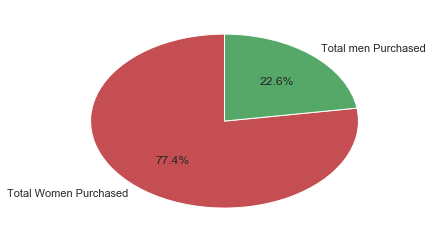

In [19]:
TNF = df["sumFemale"].sum()
TNM = df["summale"].sum()
slices_hours = [TNF,TNM]
activities = ['Total Women Purchased', 'Total men Purchased']
colors = ['r', 'g']
plt.pie(slices_hours, labels=activities, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

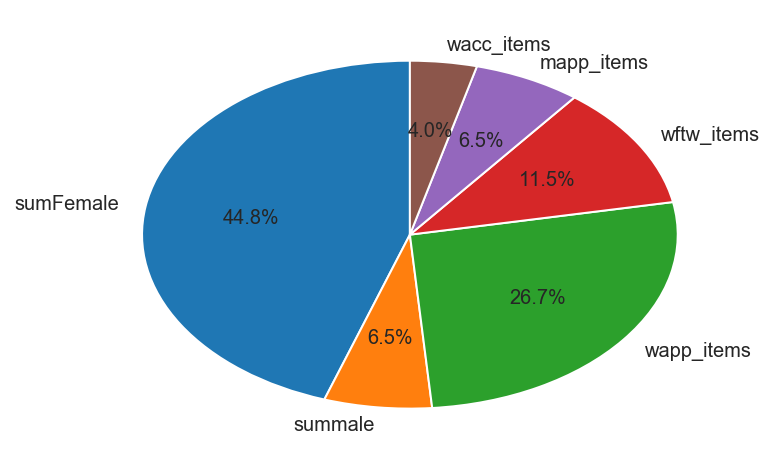

In [24]:
FI = df["sumFemale"].sum()
MI = df["summale"].sum()
WI = df["wapp_items"].sum()
WFI = df["wftw_items"].sum()
MI = df["mapp_items"].sum()
WCI = df["wacc_items"].sum()
WSI = df["wspt_items"].sum()
MSI = df["mspt_items"].sum()
slices_hours = [FI,MI,WI,WFI,MI,WCI]
activities = ['sumFemale', 'summale',"wapp_items","wftw_items","mapp_items","wacc_items"]
# colors = ['r', 'g']
plt.pie(slices_hours, labels=activities,  startangle=90, autopct='%.1f%%')
plt.show()

### Four SQL Questions:

#### 1) What was the total revenue to the nearest dollar for customers who have paid by credit card?

In [10]:
pd.read_sql_query("select round(sum(revenue)) as Question1 from customers where cc_payments > 0 ",con)

,Question1
0,50372282.0


#### 2) What percentage of customers who have purchased female items have paid by credit card?


In [9]:
q2 = pd.read_sql_query("select 100 * sum(cc_payments)/sum(cc_payments + paypal_payments + afterpay_payments + apple_payments) as Question2 from customers where female_items > 0 and cc_payments > 0",con)
q2.rename({})

,Question2
0,74


#### 3) What was the average revenue for customers who used either iOS, Android or Desktop?


In [11]:
pd.read_sql_query("select round(avg(revenue),2) as Question3 from customers where ios_orders > 0 or android_orders > 0 or desktop_orders > 0",con)

,Question3
0,1484.89


#### 4) We want to run an email campaign promoting a new mens luxury brand. Can you provide a list of customers we should send to?

#### NOTE: Need to define the definition of "luxury brand". I put two definitions (1) simply the condition of mapp_items > 0, and (2) find the top value items by calculating "revenue/male_items", and then sort it. 


In [13]:
#First definition
pd.read_sql_query("select customer_id as Question4 from customers where male_items order by revenue/male_items ",con) 

#Second Definition
pd.read_sql_query("select customer_id as Question4 from customers where mapp_items > 0",con) 


,Question4
0,64f7d7dd7a59bba7168cc9c960a5c60e
1,18923c9361f27583d2320951435e4888
2,aa21f31def4edbdcead818afcdfc4d32
3,7dae973c589d913f4ca4dacbd37feedf
4,040fb9742f9e14cf69c7a748bdf20137
5,4167f9c83bfb97a15223bb729b79b5ac
6,d439bd758fd2f20aca559a60a53a3b69
7,37f5af5042258835bb444eb120265259
8,e59717d9ec9c62b7966cef921323948a
9,2615678b8425cf1a9dd4989595be806a


#### Investigate the relationship between attributes

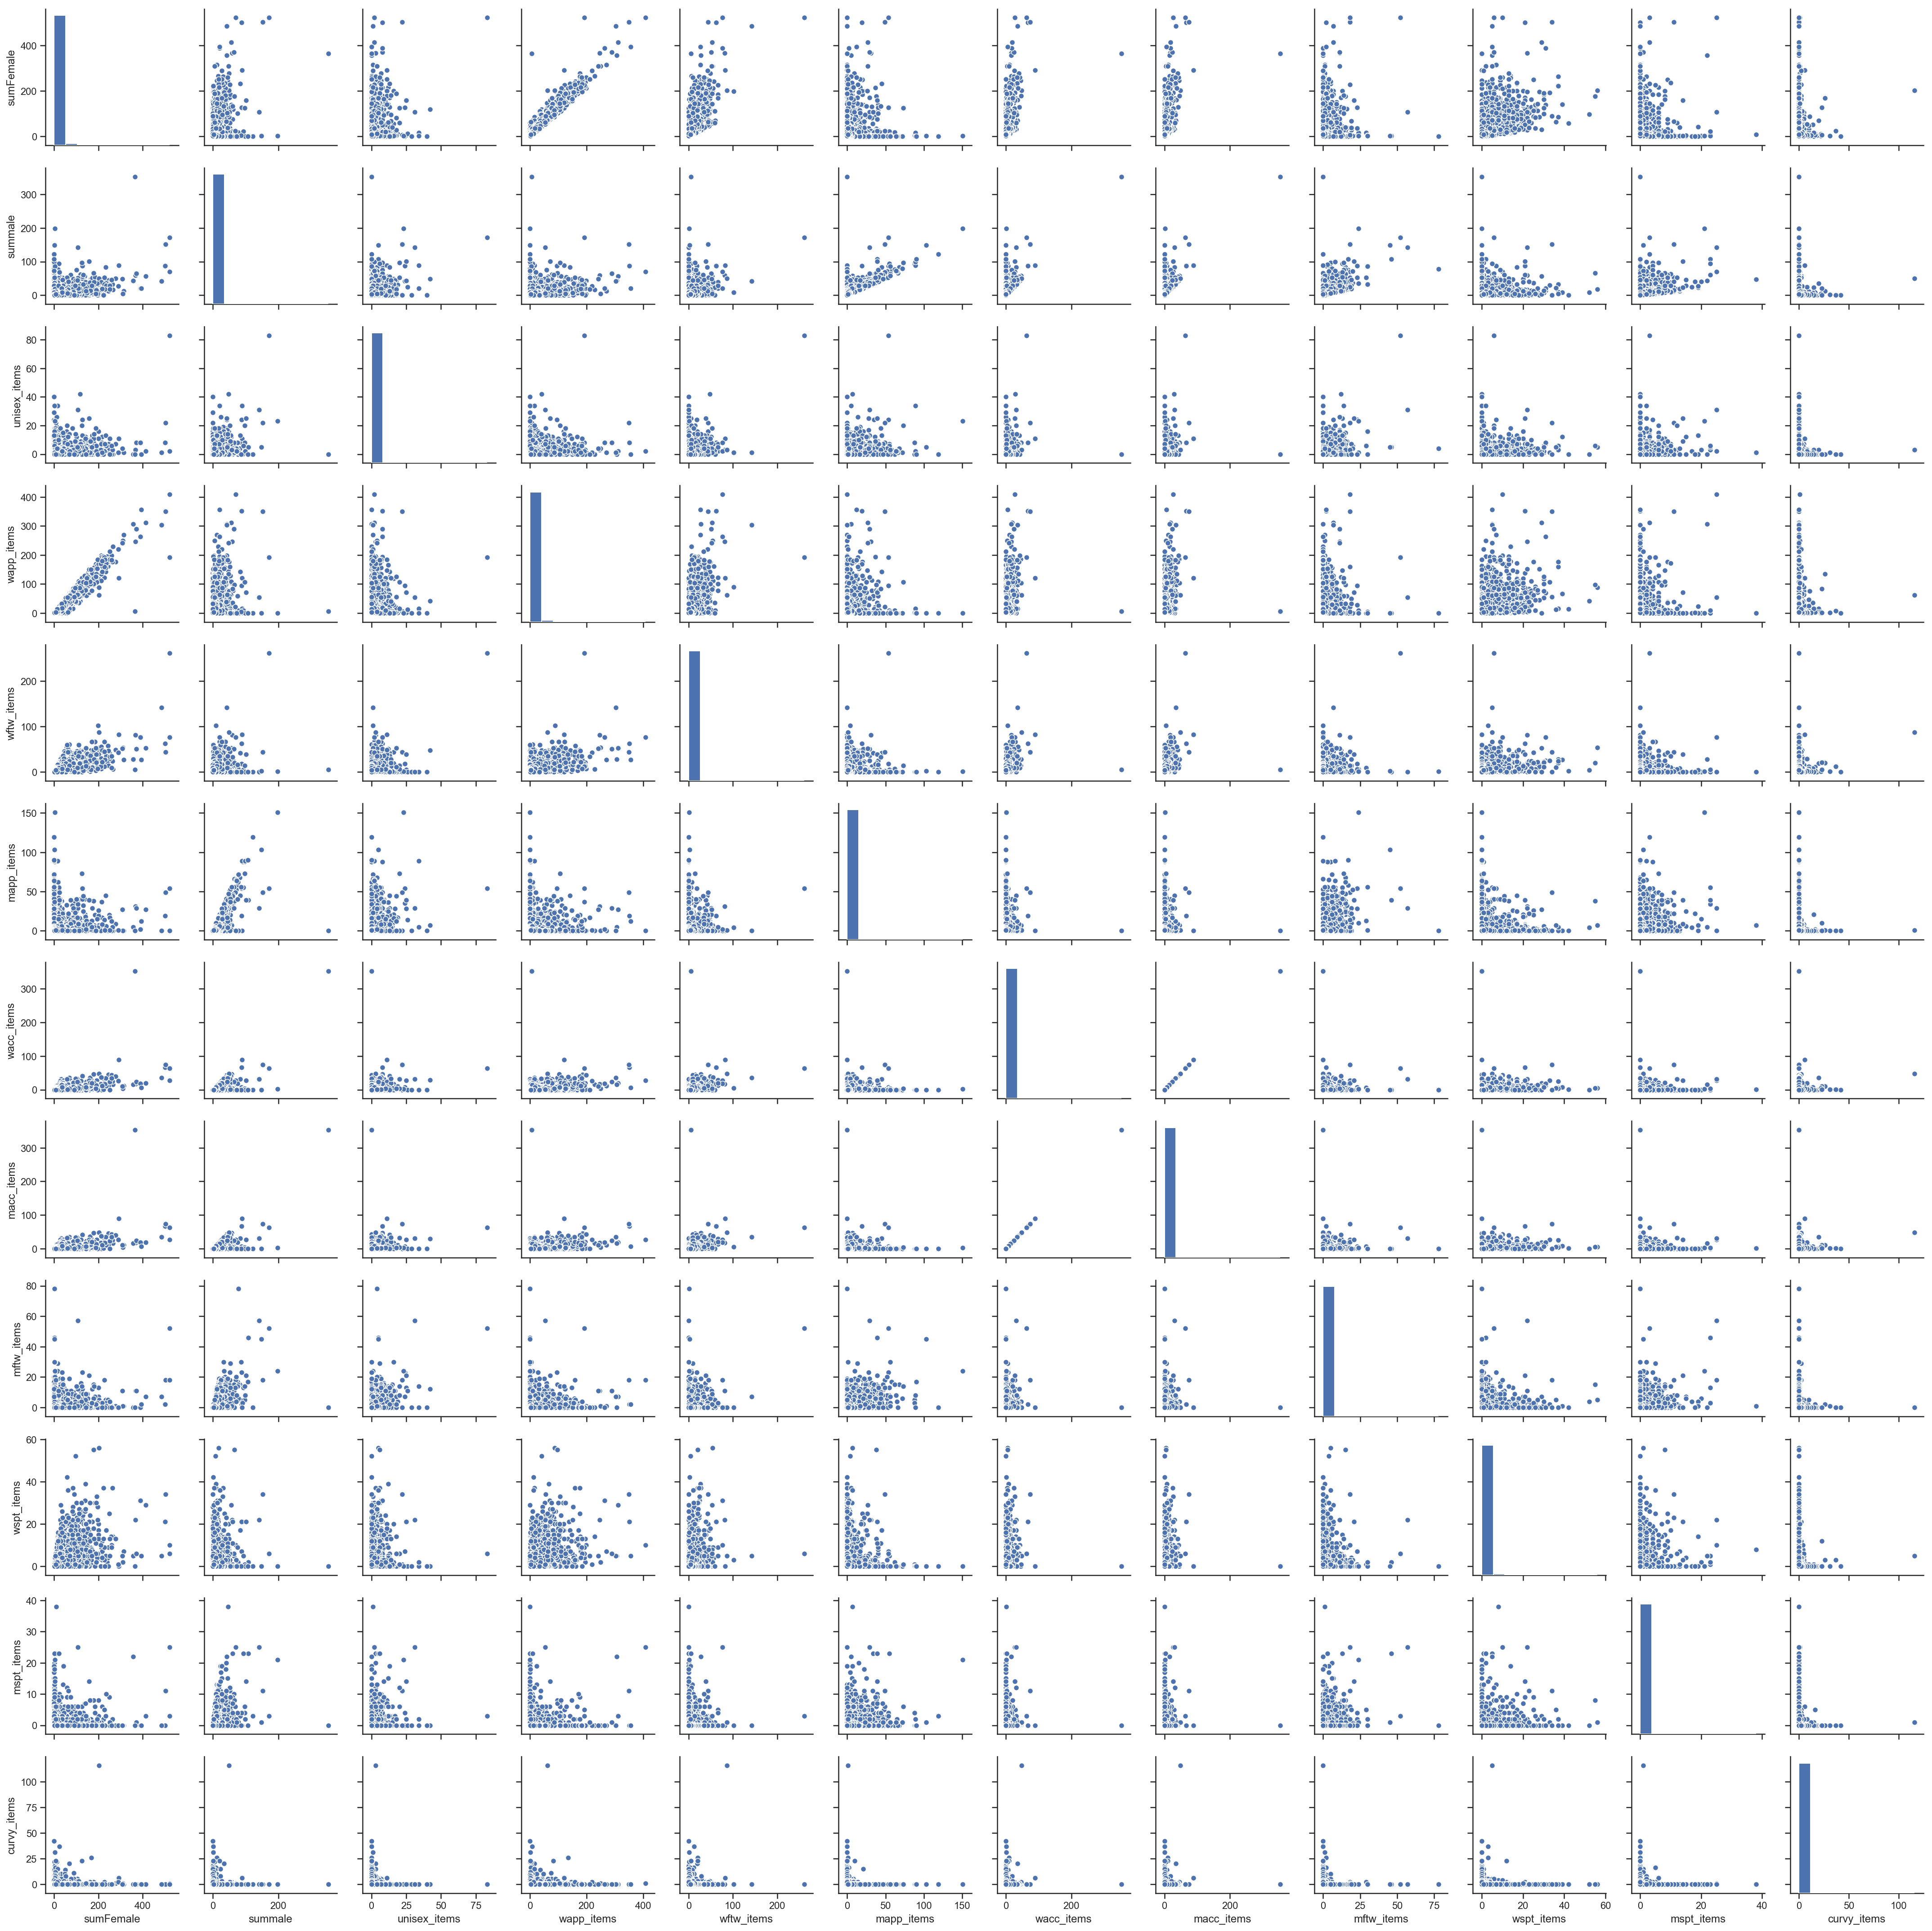

In [25]:
_list = ['sumFemale', 'summale', 'unisex_items', 'wapp_items',
       'wftw_items', 'mapp_items', 'wacc_items', 'macc_items', 'mftw_items',
       'wspt_items', 'mspt_items', 'curvy_items']

import seaborn as sns; sns.set(style="ticks", color_codes=True)
sns.pairplot(df[_list])

#### As seen from above, there are negative relationships almost between the most of woman purchases and man purchases. For example, not only on female items vs male items, but also on different item comparison such as Women Footwear purchases vs Men Apparel purchases, as following.

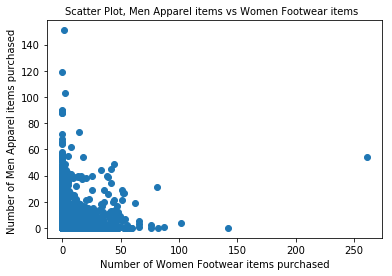

In [8]:
plt.scatter(y=df['mapp_items'].values, 
                            x=df['wftw_items'].values)

plt.xlabel('Number of Women Footwear items purchased',fontsize=10)
plt.ylabel('Number of Men Apparel items purchased ',fontsize=10)
plt.title('Scatter Plot, Men Apparel items vs Women Footwear items  ',fontsize=10)
plt.legend()


## Step 3 Feature Enginerring: 
##### Considering the relationship between the attributes, the following new features are defined to enhance the learning process in modelling part.

In [5]:
#medianFemale is the median of numbers of all purchases related to Women
df["medianFemale"]=df[['female_items','wapp_items','wftw_items', 'wacc_items', 'wspt_items']].median(axis=1)
#medianmale is the median of numbers of all purchases related to men
df["medianmale"]=df[['male_items', 'mapp_items', 'macc_items', 'mftw_items','mspt_items']].median(axis=1)

In [6]:
df.head()

,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue,sumFemale,summale,medianFemale,medianmale
0,64f7d7dd7a59bba7168cc9c960a5c60e,2091,15672,N,17,50,0,1,0,4,1,3,1,0,0,0,46,2,2,35,7,2,1,1,0,4,0,0,0,0,17,0,0,0,0,1,0,16,4554.39,248.65,0.3364,3584.4818,6946.34,93,5,7.0,1.0
1,fa7c64efd5c037ff2abcce571f9c1712,2082,528,Y,13,26,0,5,0,4,2,0,0,1,0,0,24,0,2,16,2,0,4,4,0,3,0,0,0,12,1,0,0,0,0,9,0,4,629.03,0.00,0.1404,1404.0966,5329.28,49,4,4.0,0.0
2,18923c9361f27583d2320951435e4888,2072,144,Y,71,152,2,2,1,6,2,3,1,0,1,0,147,3,2,96,33,2,17,17,0,3,0,0,0,10,61,0,0,0,0,11,0,60,6269.71,107.92,0.1851,1899.7270,14133.87,296,22,33.0,2.0
3,aa21f31def4edbdcead818afcdfc4d32,2054,49200,Y,2,2,0,0,0,1,1,1,1,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0.00,90.90,0.0000,3875.6715,143.64,1,1,0.0,0.0
4,668c6aac52ff54d4828ad379cdb38e7d,2053,49272,Y,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,0.00,2,0,0.0,0.0


## Step 4: Build the Model

#### Focus on the selected featuers from Step 3 (Relationship) and the feature engineering step

In [20]:
_list = ['female_items', 'male_items', 'unisex_items', 'wapp_items',
       'wftw_items', 'mapp_items', 'wacc_items', 'macc_items', 'mftw_items',
       'wspt_items', 'mspt_items', 'curvy_items','sumFemale','medianFemale','summale',"medianmale"]

df = df[_list]
print(df.shape)

(46030, 16)


#### Convert the input to Keras tensors, Autoencoder architecture, and training.

In [1]:
#Convert the input to keras tensors
input_= Input(shape=(16,))
print(input_)

#Autoencoder architecture (encoding)
encoded = Dense(units=128, activation='relu')(input_)
encoded = Dense(units=64, activation='relu')(encoded)
encoded = Dense(units=32, activation='relu')(encoded)

#Autoencoder architecture (decoding)
decoded = Dense(units=64, activation='relu')(encoded)
decoded = Dense(units=128, activation='relu')(decoded)
decoded = Dense(units=16, activation='sigmoid')(decoded)

#### In the final layer where I reconstruct the input I use sigmoid activation function. The output layer needs to predict the probability of an output which needs to either 0 or 1 and hence I use sigmoid activation function.

#### Now, I create the autoencoder with input data as the input. Output will be the final decoder layer

In [71]:
autoencoder=Model(input_, decoded)


#### Now, I can extract the encoder which takes input data as the input and the output of encoder is the encoded data of dimension 32

In [73]:
encoder = Model(input_, encoded)

#### let’s view the structure of the deep autoencoder model

In [74]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                2064      
Total para

#### let’s see the structure of the encoder

In [75]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
Total params: 12,512
Trainable params: 12,512
Non-trainable params: 0
_________________________________________________________________


#### I compile the autoencoder model with adam optimizer. As the output is binary, so I use binary_crossentropy as the loss function. I use accuracy as the metrics used for the performance of the model. I finally train the autoencoder using the all data with 50 epochs and batch size of 256.

#### NOTE: I consider all data for training and do not split them into train and test. There are two reasons for that, first, I am more into capture the trend from data, and second, I do not have that much data for training and feeding to a deep learning technique. This limitation also forces me to create just 3 dense layer in the Autoencoder structure.  

In [76]:
X_train=df
X_test=df
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [78]:
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 46279 samples, validate on 46279 samples
Epoch 1/50
46279/46279 [==============================] - 1s 26us/step - loss: -26.1141 - acc: 0.4532 - val_loss: -28.7723 - val_acc: 0.6388
Epoch 2/50
46279/46279 [==============================] - 1s 14us/step - loss: -28.9475 - acc: 0.6774 - val_loss: -29.2808 - val_acc: 0.7192
Epoch 3/50
46279/46279 [==============================] - 1s 14us/step - loss: -29.5563 - acc: 0.7421 - val_loss: -29.5396 - val_acc: 0.7488
Epoch 4/50
46279/46279 [==============================] - 1s 14us/step - loss: -29.7426 - acc: 0.7610 - val_loss: -29.8275 - val_acc: 0.7672
Epoch 5/50
46279/46279 [==============================] - 1s 14us/step - loss: -29.8200 - acc: 0.7681 - val_loss: -29.8699 - val_acc: 0.7729
Epoch 6/50
46279/46279 [==============================] - 1s 14us/step - loss: -29.8676 - acc: 0.7726 - val_loss: -29.8981 - val_acc: 0.7752
Epoch 7/50
46279/46279 [==============================] - 1s 14us/step - loss: -29.8864 - acc: 0.7742 - 

In [10]:
predictions = encoder.predict(X_test)
predictions.shape


#### The accuracy in this stage is 79.14%. 

#### Save to use tensorboard for visualisation

In [35]:
np.savetxt("data_deepLayer.csv", predictions, delimiter='\t')

In [23]:
type(encoder.predict(X_test))

numpy.ndarray

#### Gaussian Mixture Models(GMM). I use GMM to fix the data points which are assigned to clusters with certain probabilities. 

#### The output of the GMM is the clustering of all 46,030 customers into 2 groups of gender.

In [83]:
x=X_test 
n_clusters=2
gmm = GaussianMixture(n_components=n_clusters, random_state=0, n_init  = 20).fit(encoder.predict(x))
y_pred = gmm.predict(encoder.predict(x))
probs = gmm.predict_proba(encoder.predict(x))

#### Save to use tensorboard for visualisation

In [36]:

# Save labels
np.savetxt("cluster_labels_onDeepLayer.csv", y_pred, delimiter=",")


### Insight

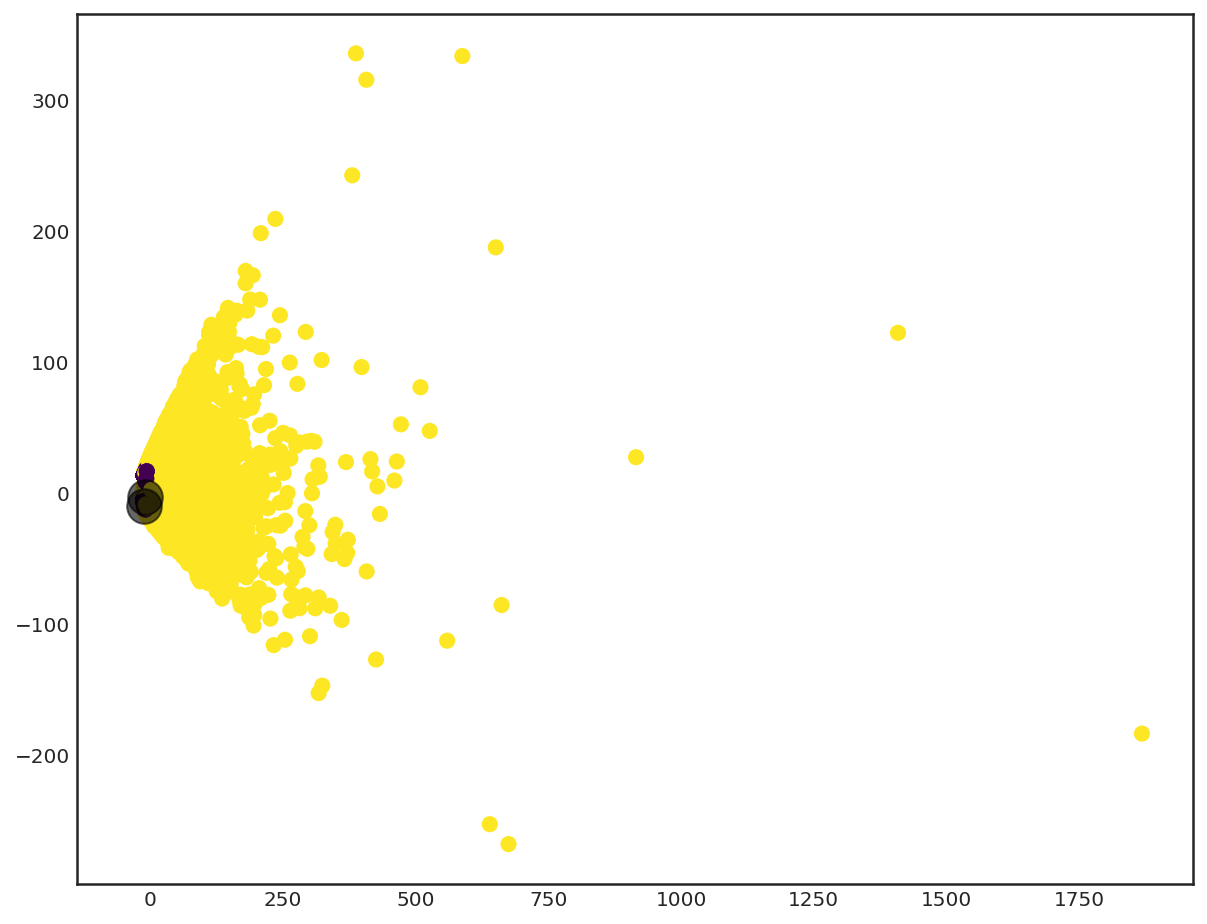

In [84]:
# finding center
sklearn_pca = PCA(n_components = 2)
x_pca = sklearn_pca.fit_transform(encoder.predict(x))

centers = np.zeros((2,2))
for i in range(2):
    density = mvn(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(encoder.predict(x))
    centers[i, :] = x_pca[np.argmax(density)]
plt.figure(figsize = (10,8))
plt.scatter(x_pca[:, 0], x_pca[:, 1],c=y_pred ,s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

#### Image captured from TensorBoard

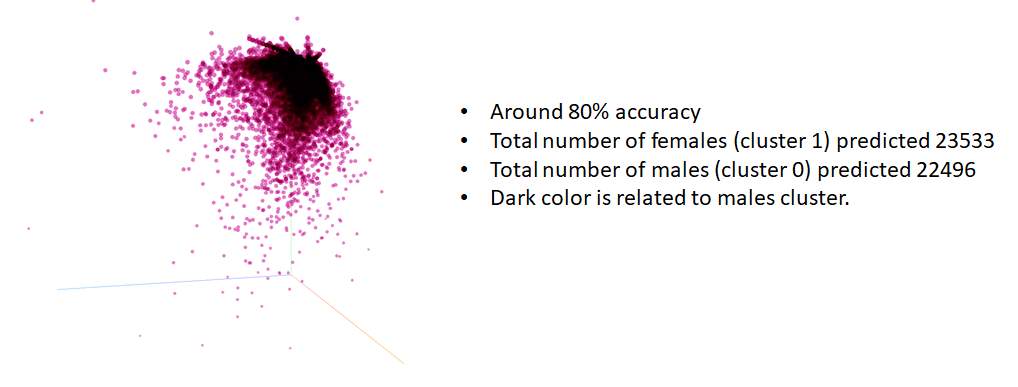

In [2]:
from IPython.display import Image
Image(filename = "clustering output.png", width=725, height=750)

In [3]:
import pandas as pd
a = pd.read_csv("cluster_labels_onDeepLayer.csv")
a = a.rename(columns = {'1.000000000000000000e+00' : "y_pred"})
a.head()

,y_pred
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0


In [22]:
a["y_pred"].shape

(46278,)

In [11]:
df["clusterLablePredicted"]=a["y_pred"]

#### Predicted 2 cluster, cluster 1 as female gender, and cluster 0 as male gender

In [12]:
df_lable_0 = df.loc[df["clusterLablePredicted"] ==0]
df_lable_1 = df.loc[df["clusterLablePredicted"] ==1]

In [38]:
#total number of females in cluster 1 predicted: 23533 
print("total number of females in cluster 1 predicted",df_lable_1.shape[0])
#total number of males in cluster 0 predicted: 22496
print("total number of males in cluster 0 predicted",df_lable_0.shape[0])

total number of females in cluster 1 predicted 23533
total number of males in cluster 0 predicted 22496


#### A sample of cluster 1, as predicted as female

In [13]:
df_lable_1.head(1)

,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,...,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue,sumFemale,summale,medianFemale,medianmale,clusterLablePredicted
0,64f7d7dd7a59bba7168cc9c960a5c60e,2091,15672,N,17,50,0,1,0,4,...,4554.39,248.65,0.3364,3584.4818,6946.34,93,5,7.0,1.0,1.0


#### A sample of cluster 0, as predicted as male

In [35]:
df_lable_0.head(1)

,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sumFemale,medianFemale,summale,medianmale,clusterLablePredicted
3,0,0,2,1,0,1,0,0,0,0,0,0,1,0.0,1,0.0,0.0


## Step 5: 

### I have created a slide deck to summarize the outcome for SMEs.

## Conclusion

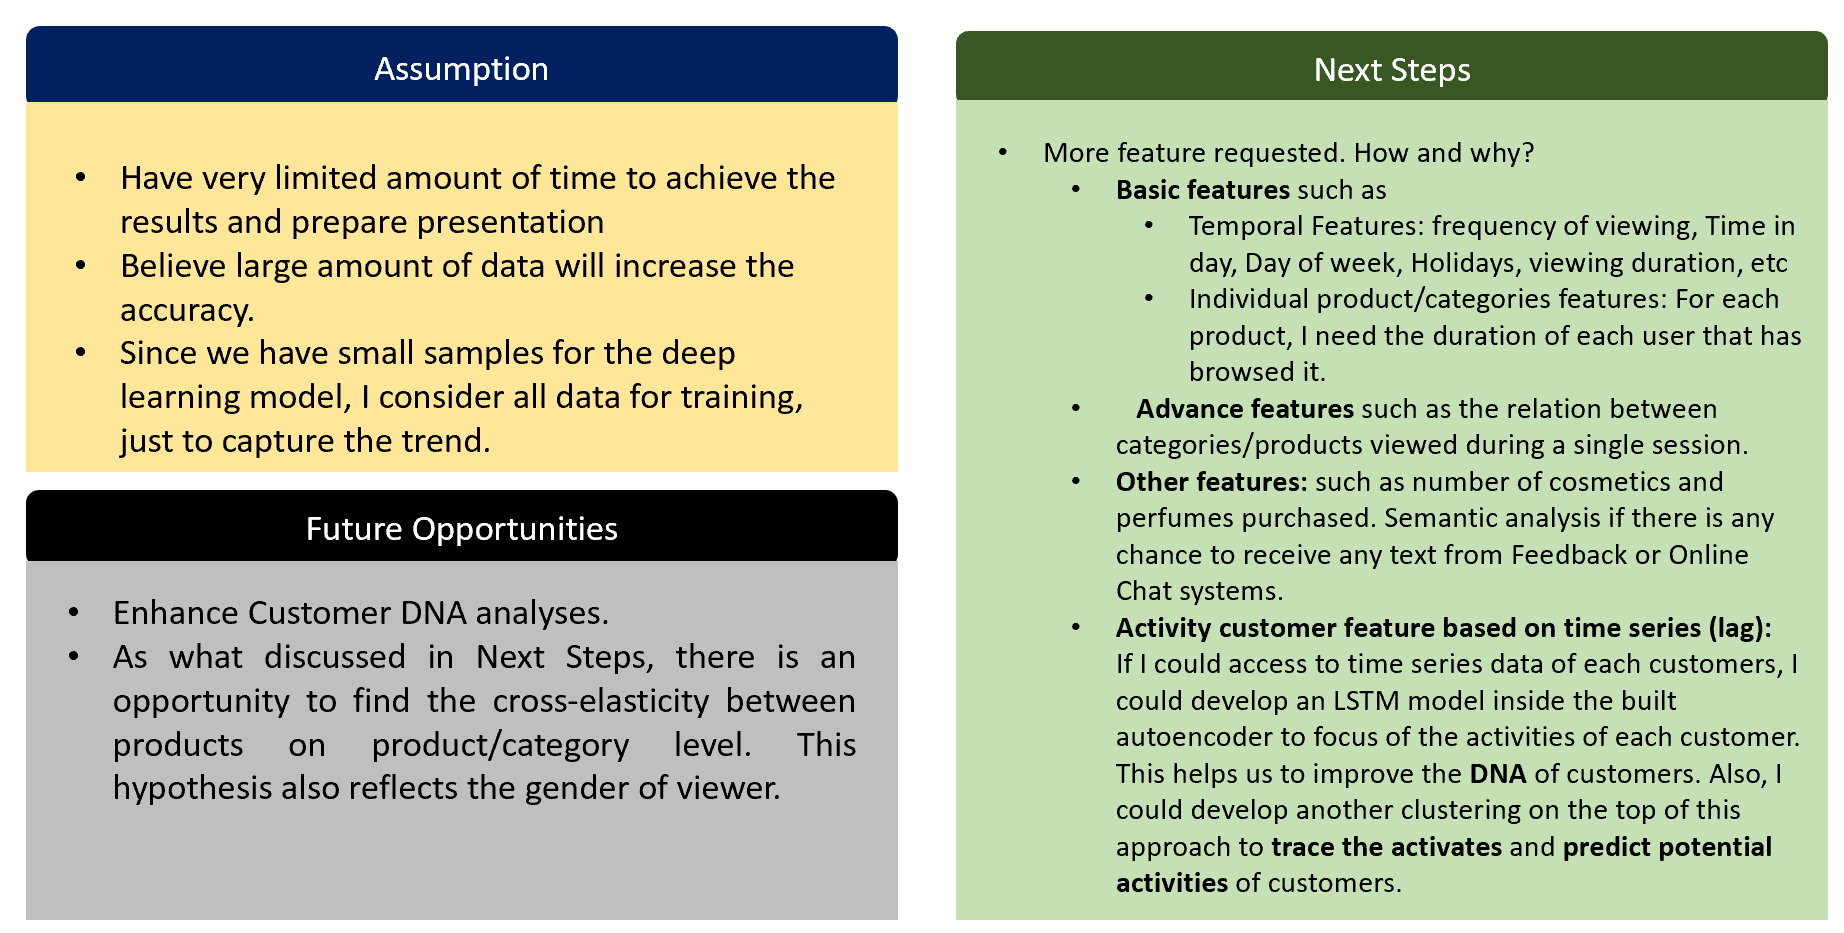

In [4]:
from IPython.display import Image
Image(filename = "conclusion.png", width=925, height=750)